In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice

Connecting hanhou@datajoint.mesoscale-activity-map.org:3306


# Ephys examples

## Histology-related

`ephys.Unit`: all units

`histology.ElectrodeCCFPosition.ElectrodePosition`: CCF location for each unit

`ccf.CCFAnnotation`: Annotation for each CCF location

Count units in each area

In [11]:
dj.U('annotation').aggr((ephys.Unit * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:10]

,count
annotation,
"Secondary motor area, layer 6a",723
Anterior olfactory nucleus,564
Mediodorsal nucleus of thalamus,464
"Secondary motor area, layer 5",422
"Orbital area, medial part, layer 5",417
"Prelimbic area, layer 5",396
Caudoputamen,391
"Orbital area, ventrolateral part, layer 5",259
Posterior complex of the thalamus,238


After unit QC (quite stringent)

In [23]:
all_unit_qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat) & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70'
dj.U('annotation').aggr(((ephys.Unit & all_unit_qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:10]

,count
annotation,
"Secondary motor area, layer 6a",226
Anterior olfactory nucleus,135
"Prelimbic area, layer 5",120
"Orbital area, medial part, layer 5",118
"Orbital area, ventrolateral part, layer 5",98
Mediodorsal nucleus of thalamus,80
"Secondary motor area, layer 5",76
Dorsal peduncular area,59
Posterior complex of the thalamus,58


All unit in Prelimbic area after QC

In [ ]:
unit_qc_prelimbic = (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "Prelimbic%"'

Unique `session` and `insertion_number` that contains Prelimbic area for Mouse HH09

(`insertion_number` could be 1, 2, or 3.  I can insert three probes at most on my current rig.)

In [32]:
dj.U('session', 'insertion_number') & (unit_qc_prelimbic & (lab.WaterRestriction & 'water_restriction_number = "HH09"'))

session session number,insertion_number
46,1
47,1
48,1


Finally, all QC-filtered prelimbic units for Mouse HH09 in Session 47.

In [35]:
unit_qc_prelimbic_HH09_session47 = unit_qc_prelimbic & (lab.WaterRestriction & 'water_restriction_number = "HH09"') & 'session = 47'
len(unit_qc_prelimbic_HH09_session47)

58

## PSTH

Pick an example neuron

In [2]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-18"' & 'subject_id = 473361') & {'insertion_number': imec + 1, 'unit_uid': unit}).fetch1("KEY")

PSTH grouped by choice and outcome

In [ ]:
_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)

PSTH grouped by quantiles of `action value`. Note that this depends on the behavioral model. (see the next section)

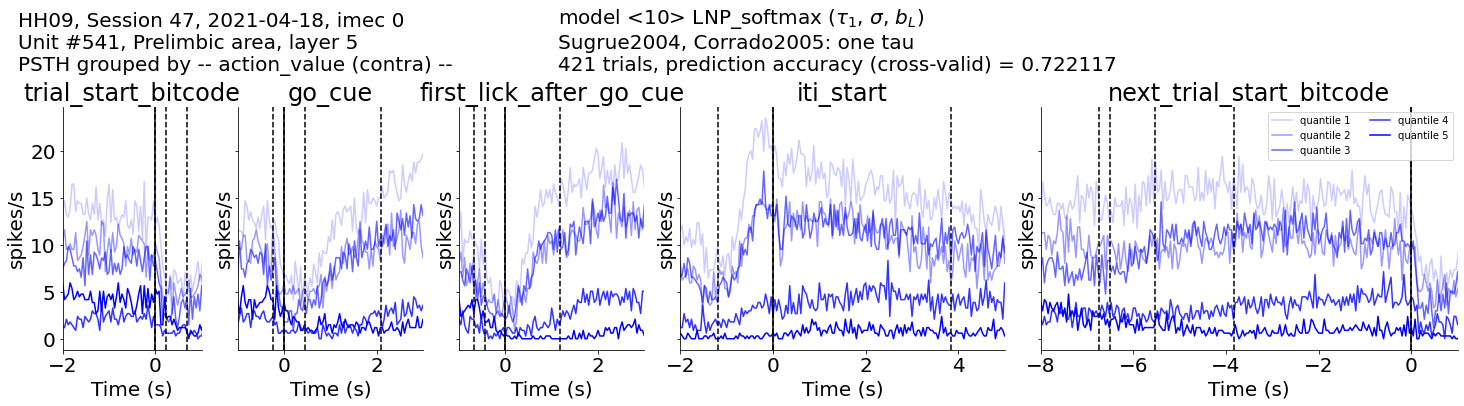

In [13]:
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

By default, `plot_unit_psth_latent_variable_quantile` plots contralateral `action value`.

You can specify other latent variables or the other side.

For example, ipsilateral choice probability:

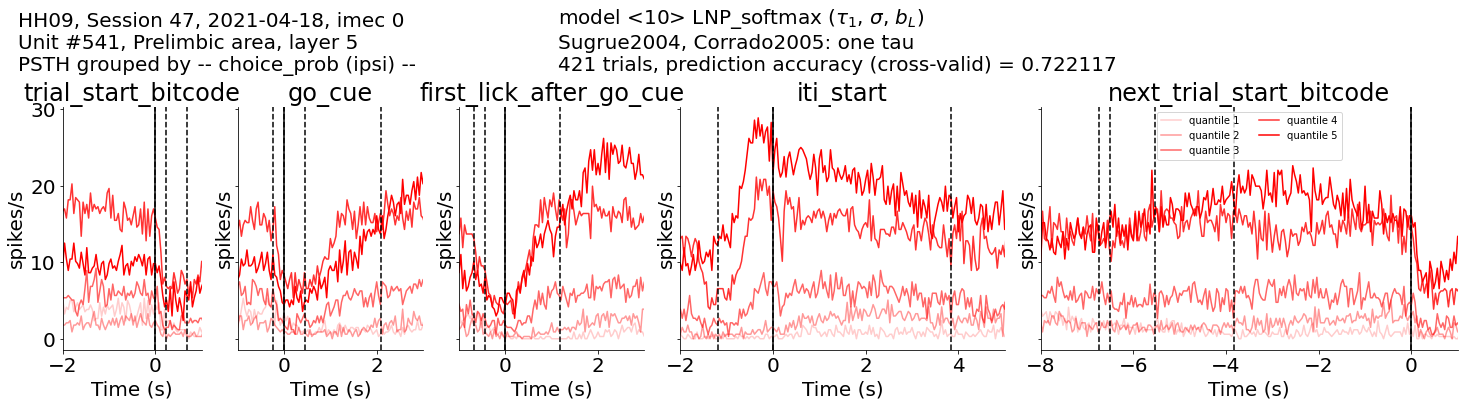

In [12]:
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10, side='ipsi', latent_variable='choice_prob')

# Model fitting results

## All models

In [2]:
foraging_model.Model()

model_id,"model_class e.g. LossCounting, RW1972, Hattori2019",model_notation,n_params Effective param count,is_bias,is_epsilon_greedy,is_softmax,is_choice_kernel,desc Long name,fit_cmd Fitting command compatible with the Dynamic-Foraing repo
0,LossCounting,"LossCounting ($\mu_{LC}$, $\sigma_{LC}$)",2,0,0,0,0,"LossCounting: mean, std, no bias",=BLOB=
1,RW1972,"RW1972_epsi ($\alpha$, $\epsilon$)",2,0,1,0,0,"SuttonBarto: epsilon, no bias",=BLOB=
2,RW1972,"RW1972_softmax ($\alpha$, $\sigma$)",2,0,0,1,0,"SuttonBarto: softmax, no bias",=BLOB=
3,LNP,"LNP_softmax ($\tau_1$, $\sigma$)",2,0,0,1,0,"Sugrue2004, Corrado2005: one tau, no bias",=BLOB=
4,LNP,"LNP_softmax ($\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$)",4,0,0,1,0,"Corrado2005, Iigaya2019: two taus, no bias",=BLOB=
5,Bari2019,"Bari2019 ($\alpha$, $\delta$, $\sigma$)",3,0,0,1,0,"RL: chosen, unchosen, softmax, no bias",=BLOB=
6,Hattori2019,"Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $\sigma$)",3,0,0,1,0,"RL: rew, unrew, softmax, no bias",=BLOB=
7,Hattori2019,"Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\sigma$)",4,0,0,1,0,"RL: rew, unrew, unchosen, softmax, no bias",=BLOB=
8,RW1972,"RW1972_epsi ($\alpha$, $\epsilon$, $b_L$)",3,1,1,0,0,SuttonBarto: epsilon,=BLOB=
9,RW1972,"RW1972_softmax ($\alpha$, $\sigma$, $b_L$)",3,1,0,1,0,SuttonBarto: softmax,=BLOB=


Show param settings of a specified model

In [4]:
foraging_model.Model.Param & 'model_id=25'

model_id,"model_param e.g. learn_rate, epsilon, w_tau1","param_idx To keep params the same order as the original definition in MODELS, hence `fit_result.x`",param_lower_bound,param_higher_bound
25,biasL,5,-5.0,5.0
25,forget_rate,1,0.0,1.0
25,I0,2,0.0,1000000.0
25,learn_rate,0,0.0,1.0
25,rho,3,-1000000.0,1000000.0
25,softmax_temperature,4,0.01,15.0


## All model comparison groups

In [3]:
foraging_model.ModelComparison()

model_comparison_idx,desc
0,all_models
1,models_with_bias
2,models_with_bias_and_choice_kernel


## Example session

`model_comparison_idx` = 1: all models with bias term<br>
`sort='aic'`: sorted by AIC, from best to worst

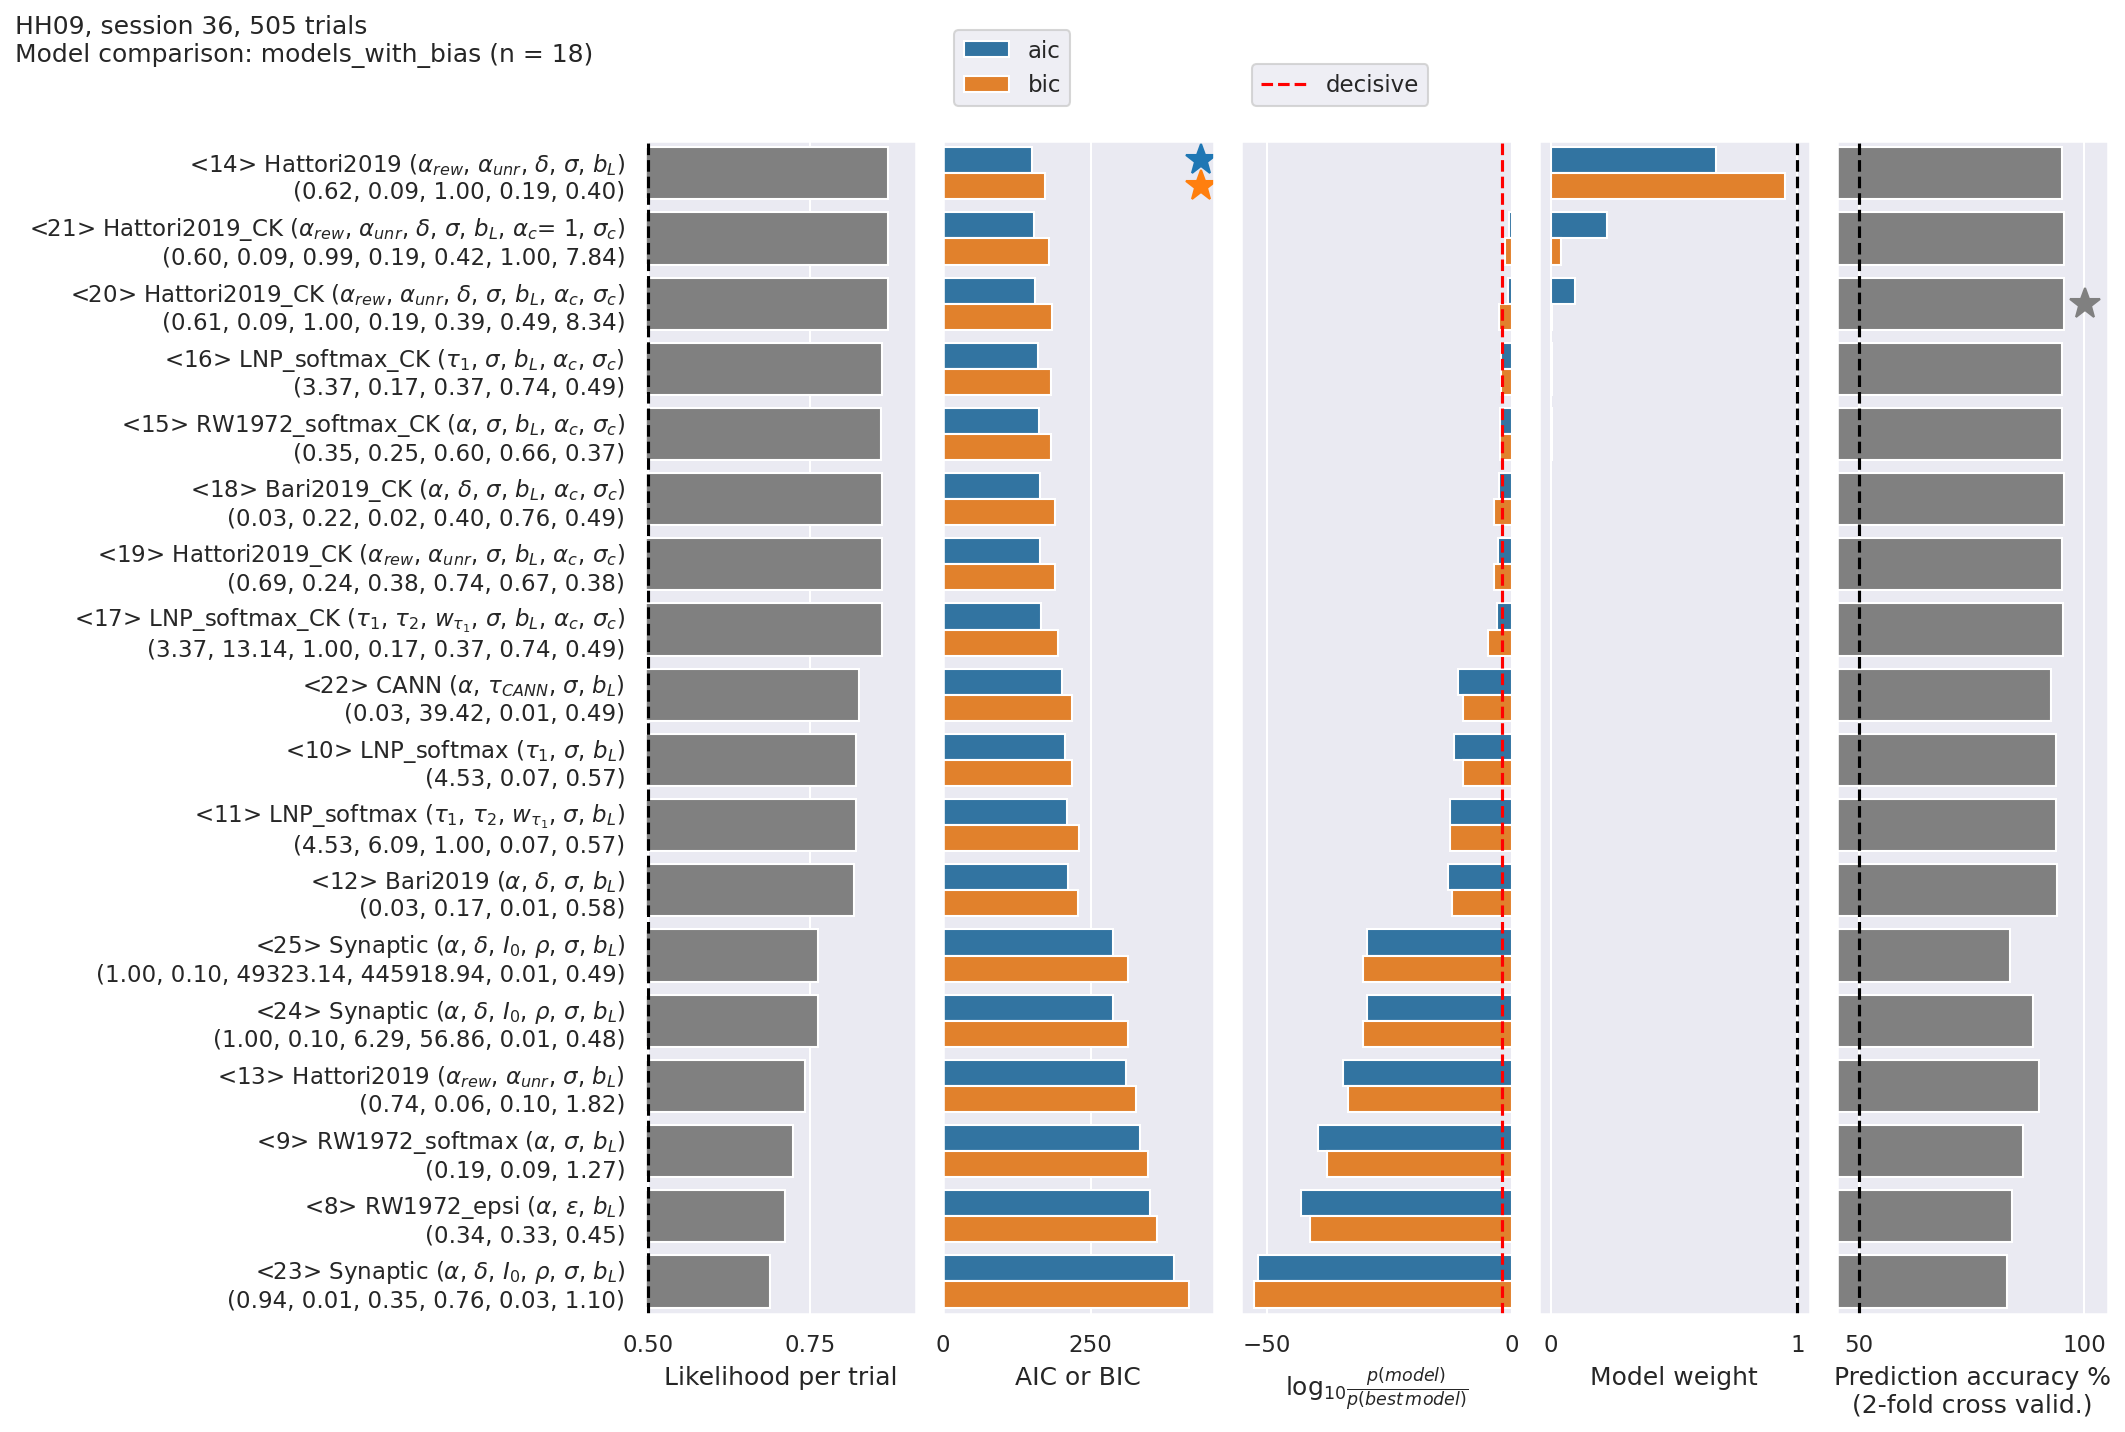

In [4]:
sess_key = {'subject_id': 473361, 'session': 36}
plot_session_model_comparison(sess_key, model_comparison_idx=1, sort='aic')

Raw fitted results

In [9]:
foraging_model.Model.proj('model_notation') * (foraging_model.FittedSessionModel & sess_key) 

model_id,subject_id institution 6 digit animal ID,session session number,model_notation,n_trials,n_params,log_likelihood raw log likelihood of the model,aic AIC,bic BIC,lpt Likelihood-Per-Trial raw,lpt_aic Likelihood-Per-Trial with AIC penalty,lpt_bic Likelihood-Per-Trial with AIC penalty,prediction_accuracy non-cross-validated prediction accuracy,cross_valid_accuracy_fit cross-validated accuracy (fitting set),cross_valid_accuracy_test cross-validated accuracy (testing set),cross_valid_accuracy_test_bias_only accuracy predicted only by bias (testing set)
0,473361,36,"LossCounting ($\mu_{LC}$, $\sigma_{LC}$)",505,2,-182.991,369.982,378.431,0.696033,0.693282,0.687506,0.918812,0.918847,0.916847,nan
1,473361,36,"RW1972_epsi ($\alpha$, $\epsilon$)",505,2,-215.631,435.262,443.711,0.652469,0.64989,0.644476,0.847525,0.845536,0.843552,nan
2,473361,36,"RW1972_softmax ($\alpha$, $\sigma$)",505,2,-199.303,402.607,411.056,0.673909,0.671245,0.665653,0.843564,0.83567,0.835694,nan
3,473361,36,"LNP_softmax ($\tau_1$, $\sigma$)",505,2,-104.699,213.398,221.847,0.812756,0.809543,0.802799,0.952475,0.952459,0.952459,nan
4,473361,36,"LNP_softmax ($\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$)",505,4,-104.67,217.339,234.237,0.812803,0.80639,0.793011,0.952475,0.948538,0.946538,nan
5,473361,36,"Bari2019 ($\alpha$, $\delta$, $\sigma$)",505,3,-106.876,219.752,232.425,0.80926,0.804467,0.794435,0.946535,0.948499,0.946538,nan
6,473361,36,"Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $\sigma$)",505,3,-197.308,400.616,413.29,0.676577,0.67257,0.664183,0.847525,0.843544,0.843544,nan
7,473361,36,"Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\sigma$)",505,4,-71.9209,151.842,168.74,0.867259,0.860417,0.846141,0.958416,0.95838,0.95838,nan
8,473361,36,"RW1972_epsi ($\alpha$, $\epsilon$, $b_L$)",505,3,-171.802,349.605,362.279,0.711626,0.707411,0.69859,0.845545,0.849442,0.839552,0.641571
9,473361,36,"RW1972_softmax ($\alpha$, $\sigma$, $b_L$)",505,3,-163.608,333.215,345.889,0.723268,0.718984,0.710019,0.865347,0.863393,0.863393,0.641579


Plot fitted choice traces of best and worst models

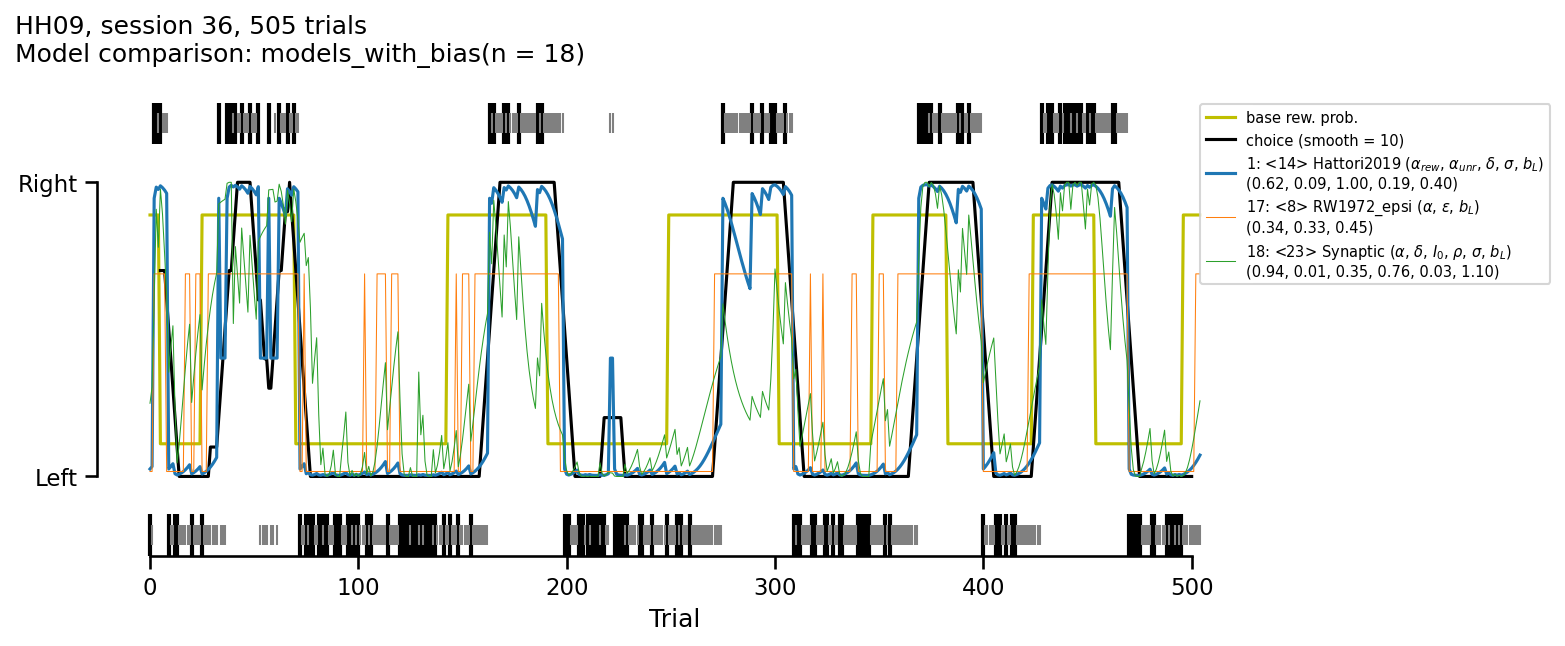

In [6]:
plot_session_fitted_choice(sess_key=sess_key, first_n=1, last_n=2, smooth_factor=10, model_comparison_idx=1)

Plot specified models

CANN model (22), Synaptic (23), and Hattori (14)

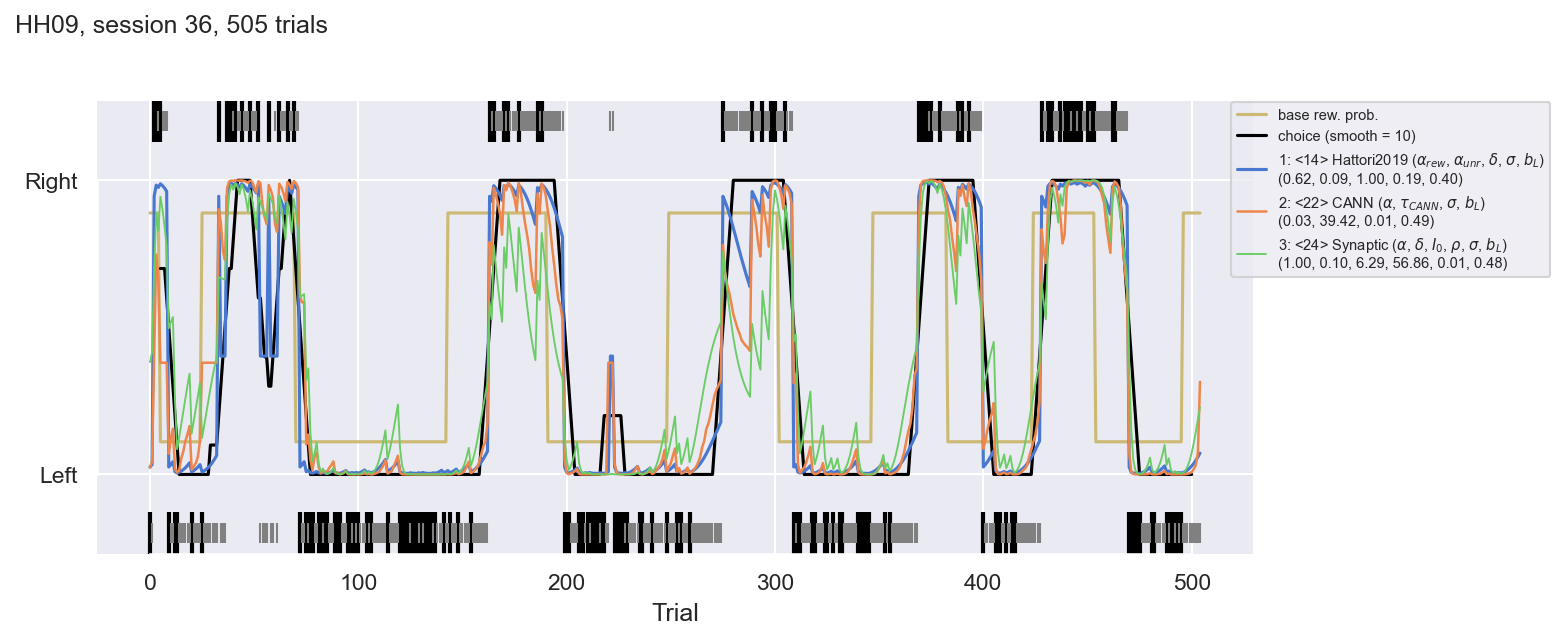

In [11]:
plot_session_fitted_choice(sess_key=sess_key, specified_model_ids=[22, 24, 14], smooth_factor=10)

## Query of fitted params

All fitted params are stored in the part table `foraging_model.FittedSessionModel.Param`

In [10]:
foraging_model.FittedSessionModel.Param.heading

# 
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
model_id             : int                          # 
model_param          : varchar(32)                  # e.g. learn_rate, epsilon, w_tau1
---
fitted_value         : float                        # 

Models from Ulises

In [60]:
Ulises_model = (foraging_model.Model & 'model_class in ("CANN", "Synaptic")')
Ulises_model

model_id,"model_class e.g. LossCounting, RW1972, Hattori2019",model_notation,n_params Effective param count,is_bias,is_epsilon_greedy,is_softmax,is_choice_kernel,desc Long name,fit_cmd Fitting command compatible with the Dynamic-Foraing repo
22,CANN,"CANN ($\alpha$, $\tau_{CANN}$, $\sigma$, $b_L$)",4,1,0,1,0,"Ulises' CANN model, ITI decay, with bias",=BLOB=
23,Synaptic,"Synaptic ($\alpha$, $\delta$, $I_0$, $\rho$, $\sigma$, $b_L$)",6,1,0,1,0,Ulises' synaptic model,=BLOB=
24,Synaptic,"Synaptic ($\alpha$, $\delta$, $I_0$, $\rho$, $\sigma$, $b_L$)",6,1,0,1,0,Ulises' synaptic model (unconstrained \rho),=BLOB=
25,Synaptic,"Synaptic ($\alpha$, $\delta$, $I_0$, $\rho$, $\sigma$, $b_L$)",6,1,0,1,0,Ulises' synaptic model (really unconstrained I_0 and \rho),=BLOB=


Show fit command

In [69]:
Ulises_model.fetch('fit_cmd')

array([list(['CANN', ['learn_rate', 'tau_cann', 'softmax_temperature', 'biasL'], [0, 0, 0.01, -5], [1, 1000, 15, 5]]),
       list(['Synaptic', ['learn_rate', 'forget_rate', 'I0', 'rho', 'softmax_temperature', 'biasL'], [0, 0, 0, 0, 0.01, -5], [1, 1, 10, 1, 15, 5]]),
       list(['Synaptic', ['learn_rate', 'forget_rate', 'I0', 'rho', 'softmax_temperature', 'biasL'], [0, 0, 0, -100, 0.01, -5], [1, 1, 10, 100, 15, 5]]),
       list(['Synaptic', ['learn_rate', 'forget_rate', 'I0', 'rho', 'softmax_temperature', 'biasL'], [0, 0, 0, -1000000.0, 0.01, -5], [1, 1, 1000000.0, 1000000.0, 15, 5]])],
      dtype=object)

Note the different bounds of $I_0$ and $\rho$ of the three Synaptic models.<br>
- `model_id = 23` --> $0 < I_0 < 10, 0 < \rho < 1$
- `model_id = 24` --> $0 < I_0 < 10, -100 < \rho < 100$
- `model_id = 25` --> $0 < I_0 < 1e6, -1e6 < \rho < 1e6$ (basically unconstrained)

Say, we're interested in the fully unconstrained Synaptic model (`model_id = 25`)

In [70]:
model_id = 25

Query ALL fitted params for one session

In [71]:
# From foraging_model.Model, we know model_id 24 is the Synaptic model
foraging_model.FittedSessionModel.Param & {'subject_id': 482350, 'session': 52, 'model_id': model_id}

subject_id institution 6 digit animal ID,session session number,model_id,"model_param e.g. learn_rate, epsilon, w_tau1",fitted_value
482350,52,25,biasL,-0.509805
482350,52,25,forget_rate,0.206364
482350,52,25,I0,109474.0
482350,52,25,learn_rate,0.625583
482350,52,25,rho,829900.0
482350,52,25,softmax_temperature,0.01


Quecy one fitted parmas, say, the `forget_rate`, for All sessions 

In [72]:
foraging_model.FittedSessionModel.Param & {'model_param': 'forget_rate', 'model_id': model_id}

subject_id institution 6 digit animal ID,session session number,model_id,"model_param e.g. learn_rate, epsilon, w_tau1",fitted_value
447921,3,25,forget_rate,1.0
447921,4,25,forget_rate,0.316802
447921,5,25,forget_rate,0.286211
447921,6,25,forget_rate,0.197288
447921,7,25,forget_rate,0.0836583
447921,8,25,forget_rate,0.215991
447921,9,25,forget_rate,0.00890963
447921,10,25,forget_rate,0.306401
447921,11,25,forget_rate,0.166334
447921,12,25,forget_rate,0.149981


Plot distributions of fitted params (`learn_rate` and `tau` of the RNN model)

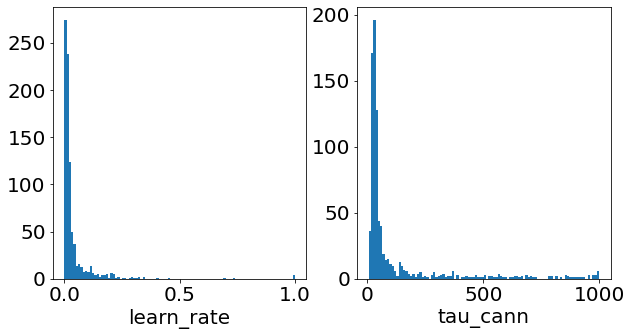

In [19]:
model_id = 22
params = ['learn_rate', 'tau_cann']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

## Problems in Synaptic model?

For `model_id = 23`,  Some fitted $\rho$s are at the boundary 0 and 1

- `model_id = 23` --> $0 < I_0 < 10, 0 < \rho < 1$

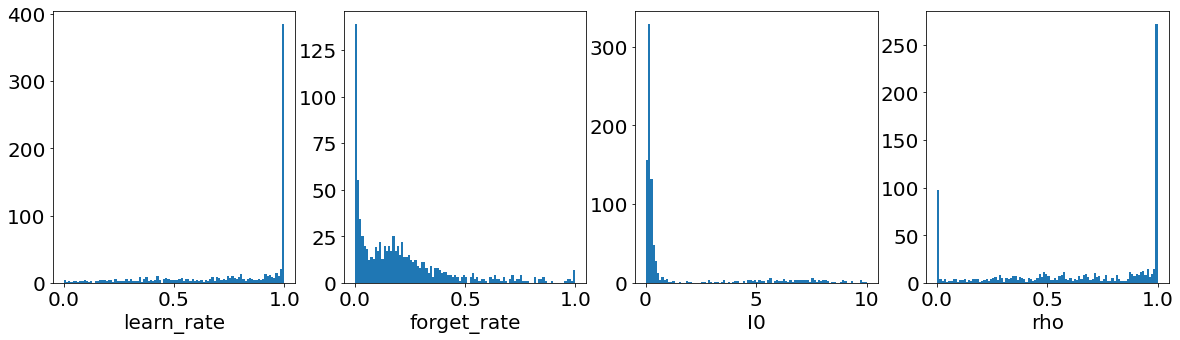

In [20]:
model_id = 23
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

- `model_id = 24` --> $0 < I_0 < 10, -100 < \rho < 100$

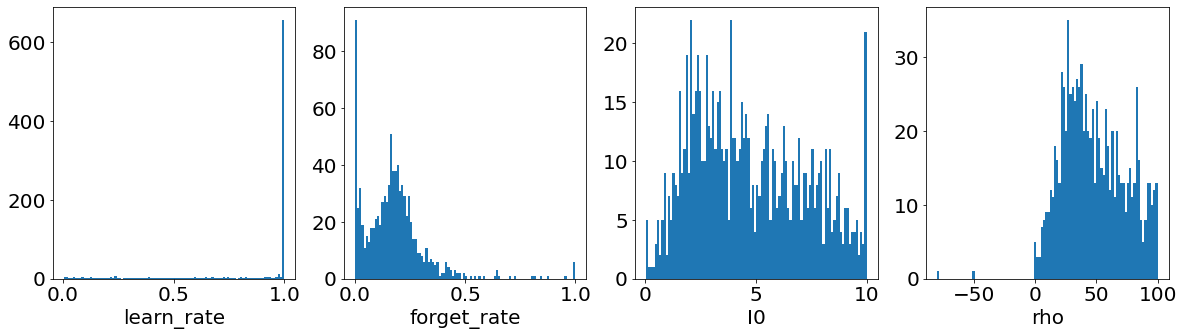

In [7]:
model_id = 24
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

- `model_id = 25` --> $0 < I_0 < 1e6, -1e6 < \rho < 1e6$ (basically unconstrained)

$\rho$ is clearly problematic if unconstrained...

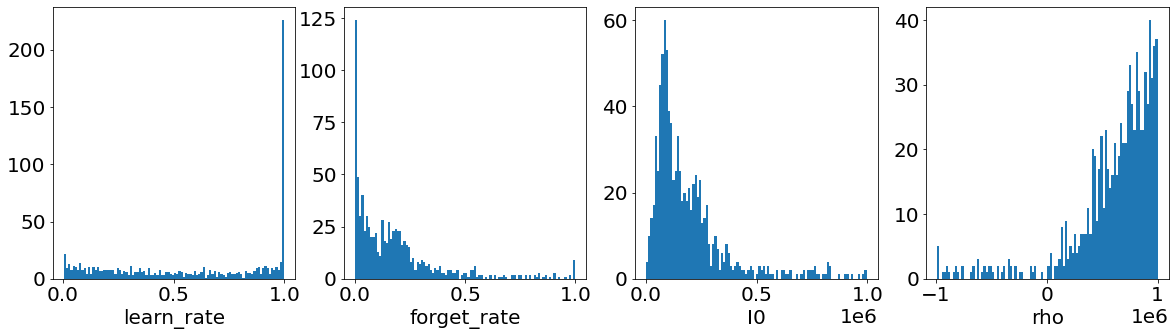

In [22]:
model_id = 25
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

In the following example, `model_id=23` failed, but `24` and `25` look fine, although there's a clear overfitting in `25` (huge $I_0$ and $\rho$)

<AxesSubplot:xlabel='Trial'>

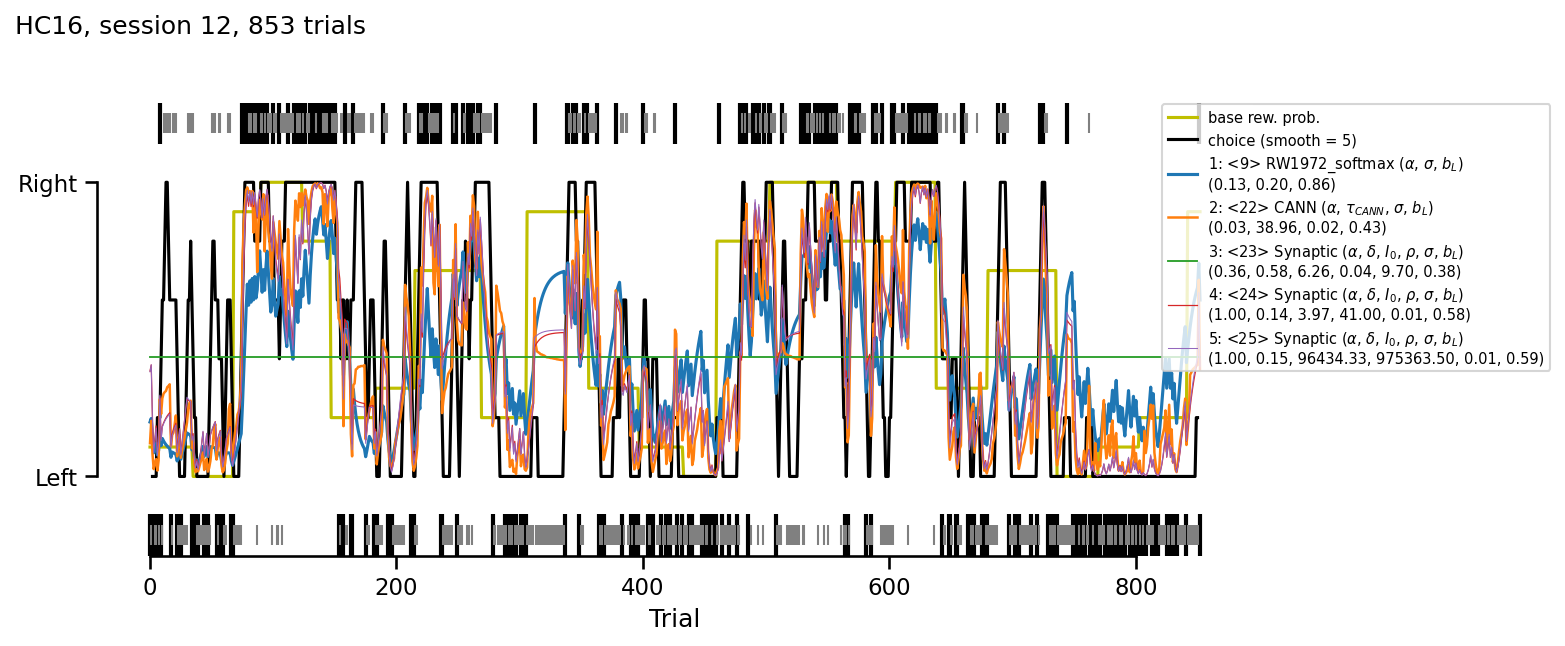

In [76]:
key = (experiment.Session & (foraging_model.FittedSessionModel & 'model_id = 23')).fetch('KEY', limit=1, offset=9)[0]
plot_session_fitted_choice(key, specified_model_ids=[9, 22, 23, 24, 25])

## Compare models by AIC

Here I'm comparing overal fitting qualities of five models

`lpt_aic` is the likelihood per trial with AIC penality (the larger, the better)

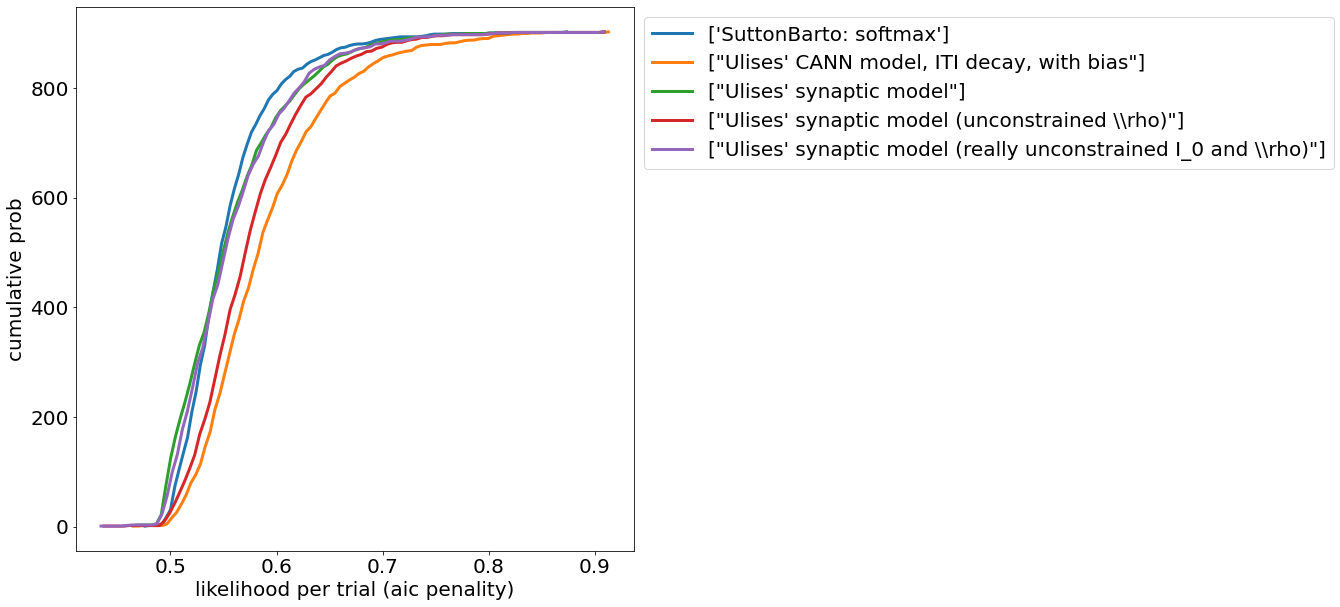

In [10]:
model_ids = [9, 22, 23, 24, 25]
_, ax = plt.subplots(1, 1, figsize=(10, 10))

for model_id in model_ids:
    lpt_aic = (foraging_model.FittedSessionModel & {'model_id': model_id}).fetch('lpt_aic')
    cnt, bin = np.histogram(lpt_aic, bins=100)
    plt.plot(bin[:-1], np.cumsum(cnt), lw=3, label=(foraging_model.Model & {'model_id': model_id}).fetch('desc'))

ax.set(xlabel='likelihood per trial (aic penality)', ylabel='cumulative prob')
_ = ax.legend(bbox_to_anchor=[1, 1])    

Conclusion:
1. `CANN` is better than `SuttonBarto` (which is the same as `CANN` except the ITI-dependent decay)
2. Mildly constrained Synaptic model `24` (red) is better than tightly constrained `23` (green) or unconstrained `25` (purple) models.

In [ ]:
sess_key = {'subject_id': 473361, 'session': 36}

# Retrieve fitted latent variables

## Action value

In current model fitting pipeline, `action value` and `choice probability` of each trial have been saved in part table `TrialLatentVariable` by default.

In [18]:
latent_variables = foraging_model.FittedSessionModel.TrialLatentVariable & sess_key & 'model_id = 24'
latent_variables

subject_id institution 6 digit animal ID,session session number,model_id,trial trial number (1-based indexing),"water_port e.g. left, right, middle, top-left, purple",action_value,choice_prob,choice_kernel
473361,36,24,3,left,0.108883,0.618114,nan
473361,36,24,3,right,0.108883,0.381886,nan
473361,36,24,4,left,0.108158,0.584698,nan
473361,36,24,4,right,0.109552,0.415302,nan
473361,36,24,11,left,0.102274,0.29915,nan
473361,36,24,11,right,0.115603,0.70085,nan
473361,36,24,14,left,0.0961682,0.110021,nan
473361,36,24,14,right,0.121889,0.889979,nan
473361,36,24,15,left,0.0986823,0.171164,nan
473361,36,24,15,right,0.119272,0.828836,nan


So we can plot the fitted `action values` (red and green, on left axis) together with the fitted choice probability (blue).

For the synaptic model, `action values` = $u_L$ and $u_R$

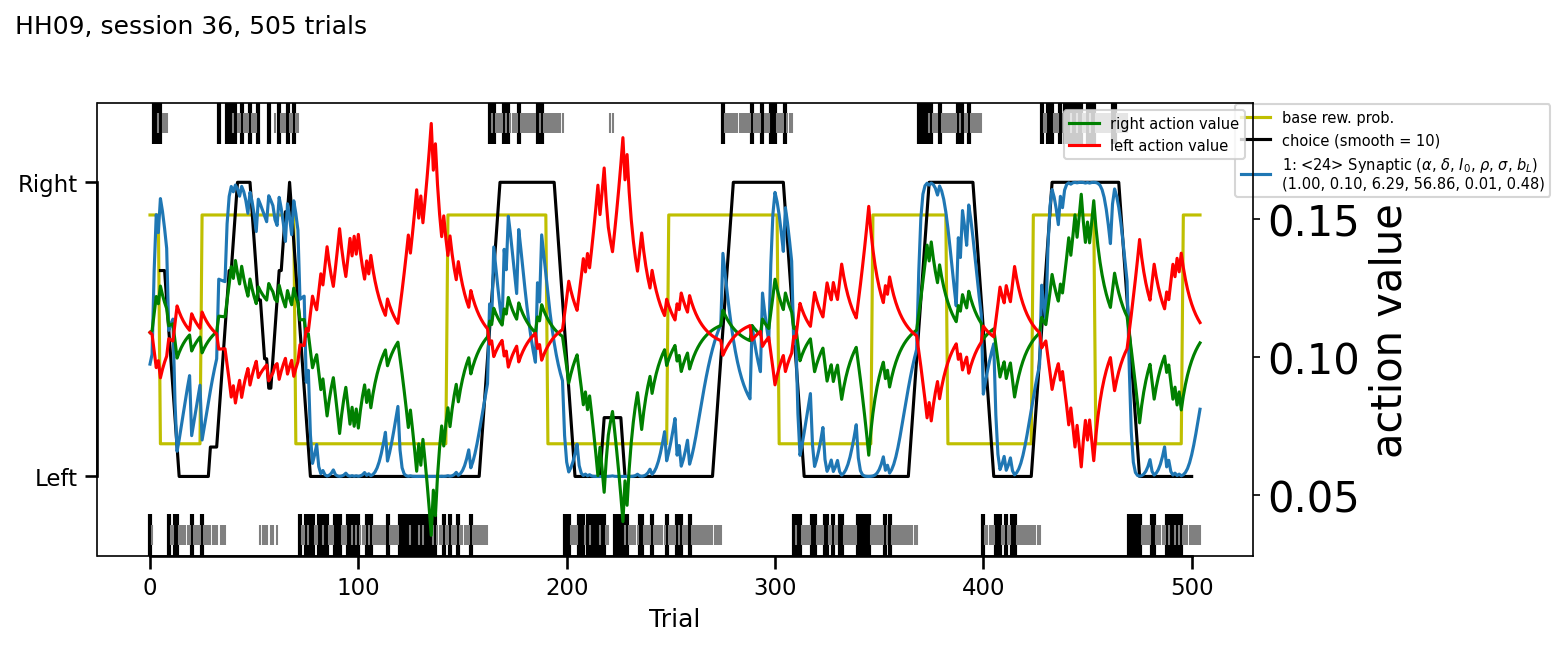

In [39]:
right_action_value = (latent_variables & 'water_port = "right"').fetch('action_value')
left_action_value = (latent_variables & 'water_port = "left"').fetch('action_value')

ax = plot_session_fitted_choice(sess_key=sess_key, specified_model_ids=24, smooth_factor=10)
ax2 = ax.twinx()
ax2.plot(right_action_value, 'g', label='right action value')
ax2.plot(left_action_value, 'r', label='left action value')
ax2.set_ylabel('action value')
ax2.legend(fontsize=7)

## $w_L(k)$ and $w_R(k)$

Unfortunately, I didn't save $w(k)$ in the latent variable table. But we can recompute them by simulating the fitted model again.

In [85]:
def plot_fitted_synaptic_w(sess_key, synaptic_model_id=24):
    # Retrieve fitted parameters
    fitted_para = (foraging_model.FittedSessionModel.Param & sess_key & f'model_id = {synaptic_model_id}').fetch()
    model_name = (foraging_model.Model & f'model_id = {synaptic_model_id}').fetch1('model_class')
    params = {name: value for (_, _, _, name, value) in fitted_para}

    # Retrieve choice and reward history
    choice_history, reward_history, iti, p_reward, q_choice_outcome = foraging_model.get_session_history(sess_key)

    # Rerun the model
    from pipeline.model.bandit_model import BanditModel
    model = BanditModel(forager=model_name, **params, fit_choice_history=choice_history, fit_reward_history=reward_history)
    model.simulate()
    
    # Plot the fitted w and the fitted choice
    w_L, w_R = model.w

    ax = plot_session_fitted_choice(sess_key=sess_key, specified_model_ids=synaptic_model_id, smooth_factor=10)
    ax2 = ax.twinx()
    ax2.plot(w_R, 'g', label='$w_R$')
    ax2.plot(w_L, 'r', label='$w_L$')
    ax2.set_ylabel('w')
    ax2.legend(fontsize=10)

Call this function with any session and any synaptic model.

The following two figures are model 23 and 24 using the same session.

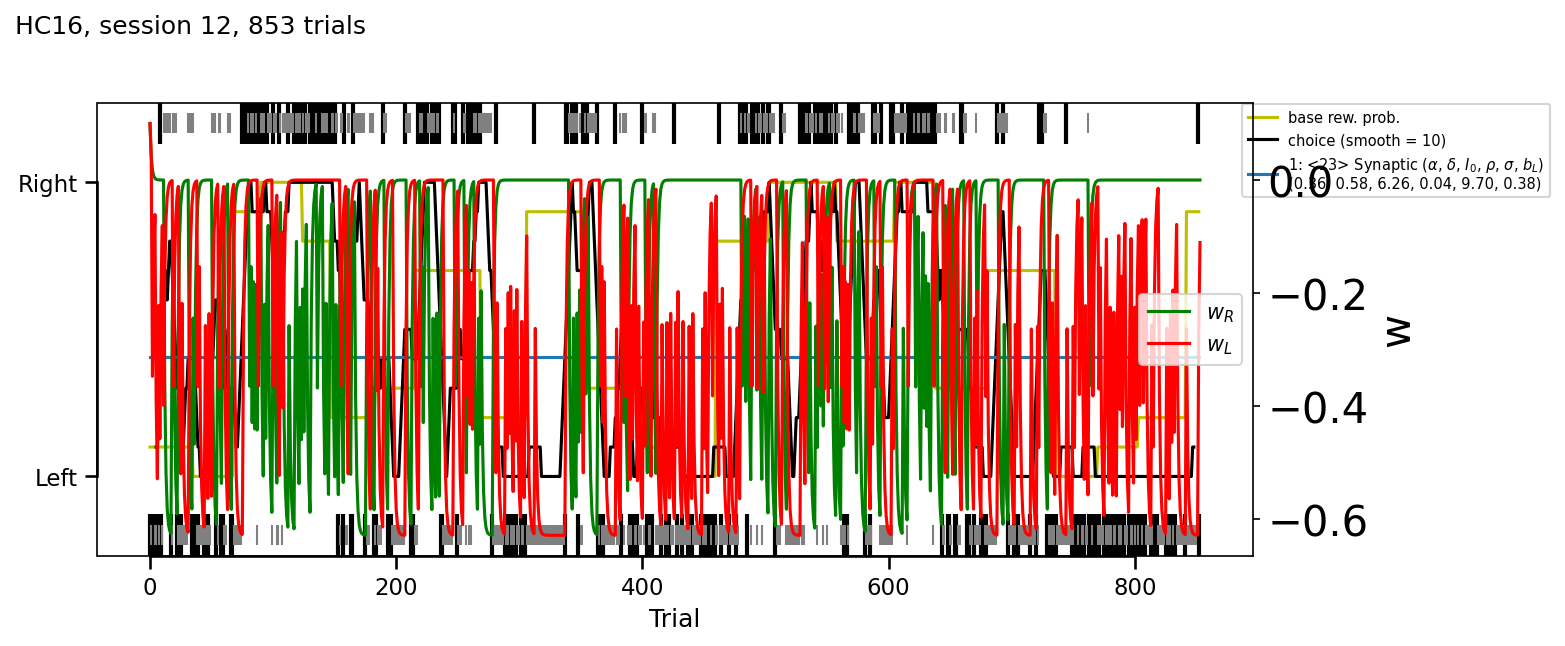

In [84]:
plot_fitted_synaptic_w(sess_key={'subject_id': 447921, 'session': 12}, synaptic_model_id=23)

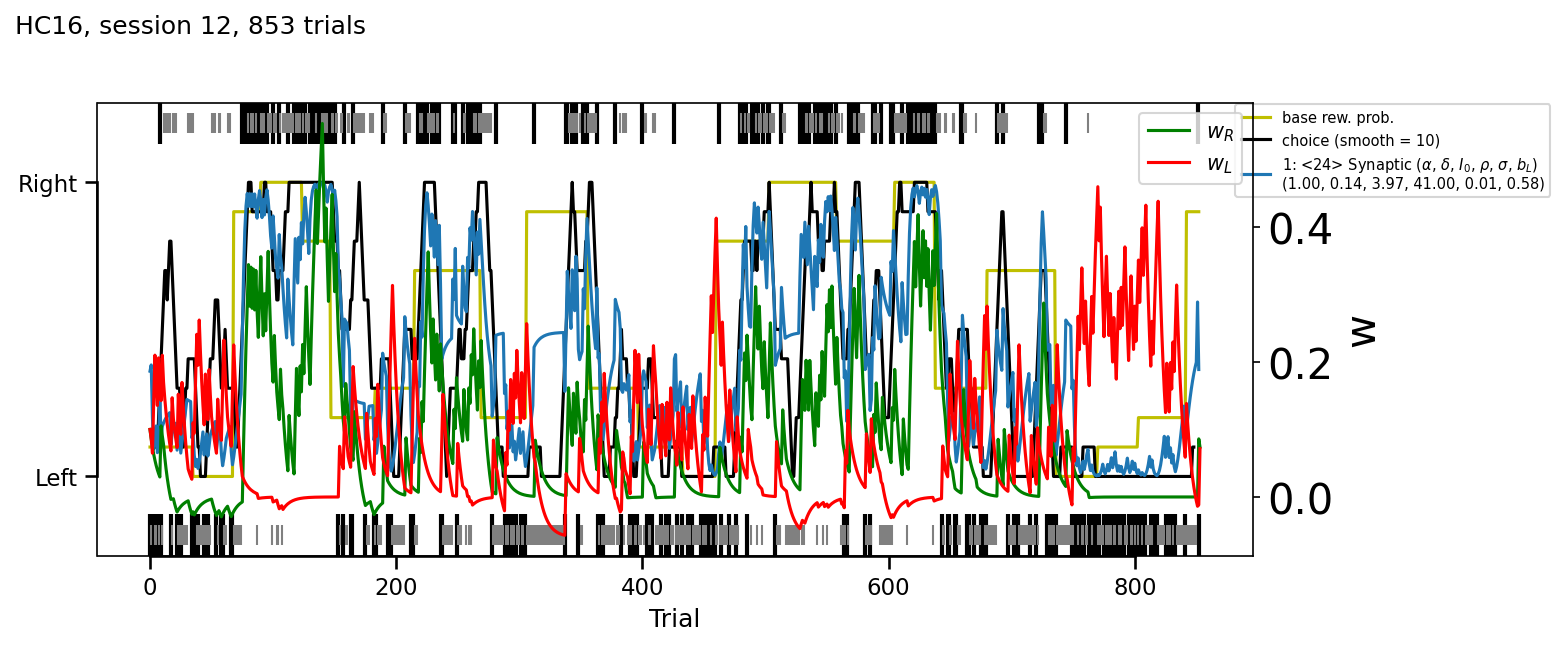

In [82]:
plot_fitted_synaptic_w(sess_key={'subject_id': 447921, 'session': 12}, synaptic_model_id=24)